# Машинное обучение. Домашняя работа №1.
### Выполнили: Ксения Самойленко и Ирина Соколова

#### Постановка задачи
В этом задании мы попытались кластеризовать новостные статьи в соответствии с определенными событиями: нам было нужно попробовать восстановить исходную кластерную структуру и посмотреть, что произойдет в случае, если мы ограничим число кластеров. Для этого мы провели предобработку данных, а также применили три алгоритма кластеризации: разделяющий алгоритм k-средних (K-means), спектральный алгоритм и аггломеративный иерархический алгоритм. 

__Алгоритм K-means__ делает заданное количество документов, находящихся не слишком близко друг к другу, центроидами, группирует в кластер ближайшие к ним документы, а затем перемещает центроиды, перегруппирует вокруг них кластер, и так до тех пор, пока центроиды не перестанут значительно перемещаться.

__Аггломеративный иерархический алгоритм__ (снизу вверх) сначала определяет каждый документ в свой собственный кластер, а затем объединяет похожие кластеры. 

__Спектральный алгоритм__ предполагает, что термины, которые часто встречаются вместе, описывают близкие понятия. То есть кластеризуются и термины, и документы: их матрица преобразуется в двудольный граф, для разбиения которого используется несколько функций.

Мы попробовали применить разные параметры (минимальную и максимальную документную частоту, tf-idf преобразование, сингулярное разложение), чтобы посмотреть, как изменится качество кластеризации. Качество измеряли несколькими способами: вычисляли однородность, полноту, V-меру и Rand Index. Однородность будет максимальна, если все документы в кластере относятся к одному классу. Полнота будет максимальна, если все документы одного класса вошли в один кластер. V-мера — это гармоническое среднее однородности и полноты, а Rand Index показывает долю документов, которые отнесены к правильному кластеру, то есть отношение "правильных ответов” ко всем ответам. 
Для всего этого мы использовали набор инструментов scikit learn. Кроме того, для предобработки и анализа документов нам потребовались пакеты pandas, re и pymorphy2. Также мы использовали библиотеку matplotlib для визуализации имеющихся данных.

In [1]:
import pandas as pd
import re
import pymorphy2 as pm

### Посмотрим, сколько статей есть о каждом событии

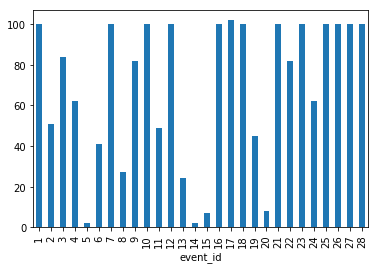

In [2]:
%matplotlib inline 
news = pd.read_csv('raw_news.csv', index_col=0)
number_of_articles = news.groupby('event_id').size()
number_of_articles.plot.bar()

In [3]:
news

,event_id,text
0,1,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1,1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П..."
2,1,"Аргументы и Факты (aif.ru), Москва, 14 января..."
3,1,"Google Новости ТОП, Москва, 14 января 2017 АК..."
4,1,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО..."
5,1,"Top Real Estate (topre.ru), Москва, 13 января..."
6,1,"Findnews.ru, Москва, 13 января 2017 ПОЛИЦИЯ Н..."
7,1,"ПРАВДА.info (pravda.info), Москва, 13 января ..."
8,1,"Голос Америки (golos-ameriki.ru), Москва, 13 ..."
9,1,"Выбор Народа (vybor-naroda.org), Москва, 13 я..."


## Часть 1. Предобработка

На этом этапе мы разбили слова на отдельные токены, приведя их к нижнему регистру, убрали лишние элементы (коими оказались ссылки) при помощи pymorphy мы лемматизировали имеющиеся слова, проверили наличие дубликатов в коллекции, после чего "слепили" их обратно в документы. 

In [1]:
morph = pm.MorphAnalyzer()
def words(str):
    nolinks = ' '.join([word for word in str.split() if (not re.findall('https?://\w.*|\w+\.\w+', word))])
    clean_line = re.sub('[\W\d_-]+', ' ', nolinks.lower().strip())
    ws = re.split(' +', clean_line)
df = pd.read_csv('raw_news.csv', index_col=0)
no_dup_df = df.drop_duplicates(keep='first')
texts = no_dup_df['text'] 
text_list = [' '.join(words(text)) for text in texts]  


NameError: name 'pm' is not defined

In [7]:
print(text_list[190])

москва февраль смерть виталий чуркин стать известный причина цвета и свеча нести к здание мид россия ряд с гвоздик и роза белый лист бумага с чёрный буква умереть виталий чуркин он стать плохо прямо на рабочий место в офис оон в нью йорк он умереть в больница от сердечный приступ заседание рабочий группа оон начаться с минута молчание а в генеральный ассамблея обещать провести в память о чуркин отдельный заседание 


## Часть 2.  Кластеризация (28 кластеров)

На этом этапе при помощи инстурментов scikit learn мы попытались кластеризовать наши документы и оценить успешность этой кластеризации. Мы применяли tf-idf меру (соотноешние встречаемости слова в документе и его встречаемость в коллекции вообще), ограничивали частоту встречаемости слова и "радиус" N-грамм. На чистоту кластеризации больше всего влияют пороги встречаемости слов. Чтобы не дублировать код по многу раз для разных параметров, мы обернули его в функцию. 

In [8]:
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

def cluster_measure(max_df, min_df, ngram_range, n_components, n_clusters):
    pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range, analyzer='word', stop_words ='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=n_components)),
      ('norm', Normalizer() ),
      ('clust', KMeans(n_clusters=n_clusters))
    ])
    pipeline.fit(text_list)
    explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    clust_labels = pipeline.named_steps['clust'].labels_
    labels = no_dup_df['event_id']
    print(len(set(clust_labels)))
    print("Homogeneity:", homogeneity_score(labels, clust_labels))
    print("Completeness:", completeness_score(labels, clust_labels))
    print("V-measure",  v_measure_score(labels, clust_labels))
    print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))
    
cluster_measure(0.9, 0.20, (1,3), 133, 28)

Explained variance of the SVD step: 99%
28
Homogeneity: 0.660355905708
Completeness: 0.641488968405
V-measure 0.650785722871
Adjusted Rand-Index: 0.422003710047


Сравним результаты для разных параметров:

In [9]:
cluster_measure(0.9, 0.20, (1,3), 65, 28)
cluster_measure(0.7, 0.10, (1,3), 65, 28)
cluster_measure(0.7, 0.10, (1,7), 65, 28)


Explained variance of the SVD step: 81%
28
Homogeneity: 0.673017325884
Completeness: 0.651842869927
V-measure 0.66226088851
Adjusted Rand-Index: 0.446721121571
Explained variance of the SVD step: 65%
28
Homogeneity: 0.865320126386
Completeness: 0.836784168475
V-measure 0.85081294326
Adjusted Rand-Index: 0.727723306481
Explained variance of the SVD step: 65%
28
Homogeneity: 0.856654309222
Completeness: 0.821037662234
V-measure 0.838467923019
Adjusted Rand-Index: 0.69740217849


Как видно из результатов, изменение параметров для сингулярного разложения слабо влияет на остальные меры. Более высоких результатов помогает добиться изменение максимальной и минимальной встречаемости слов и радиуса n-грамм. 

Мы также попробовали разбить документы на кластеры без применения tf-idf.

In [10]:
def no_tfidf(max_df, min_df, ngram_range, n_components, n_clusters): 
    pipeline = Pipeline([
        ('vect', CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range, analyzer='word', stop_words ='english')),
        ('svd', TruncatedSVD(n_components=n_components)),
        ('norm', Normalizer() ),
        ('clust', KMeans(n_clusters=n_clusters))
    ])

    pipeline.fit(text_list)
    explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    clust_labels = pipeline.named_steps['clust'].labels_
    labels = no_dup_df['event_id']
    print(len(set(clust_labels)))
    print("Homogeneity:", homogeneity_score(labels, clust_labels))
    print("Completeness:", completeness_score(labels, clust_labels))
    print("V-measure",  v_measure_score(labels, clust_labels))
    print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))
no_tfidf(0.7, 0.10, (1,3), 65, 28)

Explained variance of the SVD step: 95%
28
Homogeneity: 0.834023288761
Completeness: 0.806103187549
V-measure 0.819825594271
Adjusted Rand-Index: 0.677393625498


Как видно, результаты немного отличаются от того, что было с tfidf. Резко выросло SVD. 

### Спектральная кластеризация

In [11]:
def spectr_clust(max_df, min_df, ngram_range, n_components, n_clusters): 
    pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range, analyzer='word', stop_words ='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=n_components)),
      ('norm', Normalizer() ),
      ('clust', SpectralClustering(n_clusters=28))
    ])

    pipeline.fit(text_list)
    explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    clust_labels = pipeline.named_steps['clust'].labels_
    labels = no_dup_df['event_id']
    print(len(set(clust_labels)))
    print("Homogeneity:", homogeneity_score(labels, clust_labels))
    print("Completeness:", completeness_score(labels, clust_labels))
    print("V-measure",  v_measure_score(labels, clust_labels))
    print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))
spectr_clust(0.7, 0.10, (1,3), 65, 28) 

Explained variance of the SVD step: 65%
28
Homogeneity: 0.851059216806
Completeness: 0.81660668235
V-measure 0.833477069803
Adjusted Rand-Index: 0.701837187246


Спектральная кластеризация дает результат, не сильно отличающийся от метода K-средних, хотя число документов, отнесенных к правильном кластеру (Rand-Index) немного снижается.

### Аггломеративная кластеризация

In [12]:
def aggl_clust(max_df, min_df, ngram_range, n_components, n_clusters): 
    pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range, analyzer='word', stop_words ='english')),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=n_components)),
    ('norm', Normalizer() ),
    ('clust', AgglomerativeClustering(n_clusters=28))
    ])
        
    pipeline.fit(text_list)
    explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    clust_labels = pipeline.named_steps['clust'].labels_
    labels = no_dup_df['event_id']
    print(len(set(clust_labels)))
    print("Homogeneity:", homogeneity_score(labels, clust_labels))
    print("Completeness:", completeness_score(labels, clust_labels))
    print("V-measure",  v_measure_score(labels, clust_labels))
    print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))
    
aggl_clust(0.7, 0.10, (1,3), 65, 28) 

Explained variance of the SVD step: 65%
28
Homogeneity: 0.87181420404
Completeness: 0.842062944467
V-measure 0.856680347622
Adjusted Rand-Index: 0.711196492908


Также довольно высокие показатели. Спектральная и аггломеративная кластеризация могут быть неплохой альтернативой методу k-средних. 

## Часть 3. Кластеризация с меньшим числом кластеров.

Попробуем разбить документы на 6 кластеров при помощи имеющейся у нас функцй для разных методов.

In [13]:
cluster_measure(0.9, 0.20, (1,3), 65, 6)

Explained variance of the SVD step: 81%
6
Homogeneity: 0.336612223129
Completeness: 0.608990046904
V-measure 0.433572338071
Adjusted Rand-Index: 0.179421130744


In [14]:
spectr_clust(0.9, 0.20, (1,3), 65, 6)

Explained variance of the SVD step: 81%
28
Homogeneity: 0.675869797999
Completeness: 0.65186000581
V-measure 0.663647813262
Adjusted Rand-Index: 0.442636186841


In [15]:
aggl_clust(0.9, 0.20, (1,3), 65, 6)

Explained variance of the SVD step: 81%
28
Homogeneity: 0.683054509047
Completeness: 0.669019983102
V-measure 0.675964406923
Adjusted Rand-Index: 0.438066211887


Бросается в глаза, что для меньшего числа кластеров большую однородность дают метод спектрализации и аггломеративный метод. Кроме того, несильно, но все же вырастает Rand Index. Это позволяет предположить, что с помощью этих методов можно хотя бы примерно определить тематику событий в этих шести кластеров, чего для метода k-средних сказать нельзя. 

Ниже - не слишком симпатичное, но все-таки важное и интересное представление результатов аггломеративного разбиения на 6 кластеров: первая цифра в выводе - это номер кластера, созданного программой, а в круглых скобках - событие, отнесенное к нему и количество новостей по этой теме. Так, в первый кластер попали в основном новости об ураганах в Москве, терактах и митингах. В кластер 4 попали как новости о выборах, так и о спорте. В кластер 5 попали новости о смертях Евтушенко и Чуркина, Евровиденье, SpaceX, Исаакиевском соборе, кубке конфедераций, а также митингах и ураганах. С большой натяжкой этот кластер можно назвать посвященным новостям культуры, но в целом предположение о том, что при помощи такой кластеризации можно разбить события по темам, не оправдывается.

In [18]:
text_list2 = text_list
pipeline = Pipeline([
      ('vect', CountVectorizer(max_df=0.9, min_df=0.20, ngram_range=(1,3), analyzer='word', stop_words ='english')),
      ('tfidf', TfidfTransformer()),
      ('svd', TruncatedSVD(n_components=65)),
      ('norm', Normalizer() ),
      ('clust', AgglomerativeClustering(n_clusters=6))
])

pipeline.fit(text_list2)
explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
clust_labels = pipeline.named_steps['clust'].labels_
labels = df['event_id']

In [19]:
class TextProcessor():
    def __init__(self):
        self.ws = {}
    def send(self, word):
        if(not (word in self.ws)):
            self.ws[word] = 0
        self.ws[word] += 1
    def words(self):
        return self.ws
    def sorted(self, count):
        all = sorted(list(self.ws.items()), key=lambda w: -w[1])
        return all[:count]
realKeys = {}
for i in range(len(clust_labels)):
    if (not clust_labels[i] in realKeys):
        realKeys[clust_labels[i]] = []
    realKeys[clust_labels[i]].append(labels[i])
realSorted = {}
for k, v in realKeys.items():
    proc = TextProcessor()
    for w in v:
        proc.send(w)
    realSorted[k] = proc.sorted(100)
    
ef = pd.read_csv('events.csv', index_col=0)
evs = {}
for k in range(len(ef['name'])):
     evs[k + 1] = ef['name'][k+1]
        
pretty = {}
for k, v in realSorted.items():
    pretty[k] = [(evs[e[0]], e[1]) for e in v]
print(pretty)

{0: [('теракт произошел в центре Лондона', 94), ('Теракт в Барселоне', 91), ('Ураган в Москве', 89), ('Митинг в москве против коррупции', 86), ('Акции протеста 12 июня', 72), ('Власти Петербурга согласились передать РПЦ Исаакиевский собор.', 66), ('В центре Киева был убит бывший депутат Госдумы РФ от КПРФ Денис Вороненков', 63), ('Вышел фильм Навального «он Вам не димон»', 43), ('SpaceX впервые в истории запустила и посадила уже летавшую ракету-носитель', 41), ('Кубок конфедерации FiFA', 18), ('Умер Дэвид рокфеллер', 10), ('Дональд Трамп вступил в должность президента США.', 9), ('Единый день голосования', 8), ('Митинг против Реновации в Москве', 6), ('Саммит G20', 6), ('Победа Макрона во Франции', 5), ('Парламентские выборы в Великобритании', 5), ('Юлию Самойлову не пустили на евровидении в Киеве', 3), ('Умер Евгений Евтушенко', 3), ('Тиллерсон посещает Москву и встречается с Путиным', 3), ('Премьер Медведев выступает перед депутатами Госдумы с отчетом об итогах работы правительства з